# Library

In [1]:
import pandas as pd
import numpy as np

#process intent
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder

import random
import re

#data and layers
from sklearn.model_selection import train_test_split
import itertools
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers, Model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten, MaxPooling2D, Dropout, Conv2DTranspose, LSTM, Bidirectional, Embedding, Reshape
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from keras.optimizers import Adam

#evaluation
from keras.callbacks import TensorBoard
from tqdm import tqdm #progess bar
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

# Data

### Preprocesssing fashion mnist dataset

In [2]:
# Spilt and scale fashion mnist
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train / 255
X_test = X_test/ 255

print("-------------------------------------------------")
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

4422102/4422102 [==============================] - 0s 0us/step
-------------------------------------------------


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

### Preprocessing Intent dataset for fashion mnist dataset

In [3]:
# https://github.com/hungnq1310/hero1310/Intent.csv
import pandas as pd

data= pd.read_csv("Intent.csv", header = None)
data[0:10]

,0
0,where I can find the T-shirt/top shop;T-shirt/top
1,How were the trousers made?;Trouser
2,I would like to find a list of cool things suc...
3,the main uses of these bags?;Bag
4,the name of the dress that a person wears to ...
5,What are the most popular sneakers in the worl...
6,the status on my shirt waranty;Shirt
7,Let's being fashion with the dress in the next...
8,Make the perfect Shirt for a Special Occasion;...
9,The best Pullover Tips That'll Keep You Warm o...


In [4]:
# Fail format so I start to process the column 0
data[0]=data[0].str.split(";")
data[0][1][1].strip()

'Trouser'

In [5]:
# Clean the database
data['intent'] = [data[0][i][1].strip() for i in range(0,len(data))]
data['query'] = [data[0][i][0] for i in range(0,len(data))]
data = data[['intent','query']]
data[0:10]

,intent,query
0,T-shirt/top,where I can find the T-shirt/top shop
1,Trouser,How were the trousers made?
2,Shirt,I would like to find a list of cool things suc...
3,Bag,the main uses of these bags?
4,Dress,the name of the dress that a person wears to ...
5,Sneaker,What are the most popular sneakers in the world?
6,Shirt,the status on my shirt waranty
7,Dress,Let's being fashion with the dress in the next...
8,Shirt,Make the perfect Shirt for a Special Occasion
9,Pullover,The best Pullover Tips That'll Keep You Warm o...


#### Preprocessing intent 

In [6]:
# Convert to list
entire_sents = list(data["query"])
entire_intents = list(data["intent"])

# Prepare Labels and for every sample, assign an unique category id to each intent in a new column in dataframe.

# This method is useful for obtaining a numeric representation of an array
data['category_id'] = data['intent'].factorize()[0] 
### create new columns               ### Like enumarate function

# create new table contains intent and category_id
category_id_df = data[['intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,intent,category_id
0,T-shirt/top,0
1,Trouser,1
2,Shirt,2
3,Bag,3
4,Dress,4
5,Sneaker,5
9,Pullover,6
10,ankle-boot,7
33,Coat,8
40,Sandal,9


In [7]:
# Figure some nescessary part for later uses.
category_to_id = dict(category_id_df.values) # return dict
id_to_category = dict(category_id_df[['category_id', 'intent']].values) # return dict
id_to_category

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Shirt',
 3: 'Bag',
 4: 'Dress',
 5: 'Sneaker',
 6: 'Pullover',
 7: 'ankle-boot',
 8: 'Coat',
 9: 'Sandal'}

#### Data cleaning

In [8]:
def cleaning(sents):
    words = []
    lemmatizer = WordNetLemmatizer() # return the basic form of words
    for sent in sents:
        # Remove anything that is not alphanumeric character
        cleaned_sent = re.sub(r'[^ a-z A-Z 0-9]', " ", sent)

        # Split sentence into chunks of words i.e. tokens
        word = nltk.tokenize.word_tokenize(cleaned_sent)
        
        # Lemmatize the tokens i.e. convert it to its dictionary form
        words.append([lemmatizer.lemmatize(w.lower()) for w in word])
        
    return words

In [9]:
# The library of colab doesn't contain these libraries so I manually download it
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [10]:
# get the clean sentences of function cleaning
cleaned_entire_sents = cleaning(entire_sents)
for i in range(0,10):
  print(cleaned_entire_sents[i])

['where', 'i', 'can', 'find', 'the', 't', 'shirt', 'top', 'shop']
['how', 'were', 'the', 'trouser', 'made']
['i', 'would', 'like', 'to', 'find', 'a', 'list', 'of', 'cool', 'thing', 'such', 'a', 'nice', 'shirt']
['the', 'main', 'us', 'of', 'these', 'bag']
['the', 'name', 'of', 'the', 'dress', 'that', 'a', 'person', 'wear', 'to', 'work']
['what', 'are', 'the', 'most', 'popular', 'sneaker', 'in', 'the', 'world']
['the', 'status', 'on', 'my', 'shirt', 'waranty']
['let', 's', 'being', 'fashion', 'with', 'the', 'dress', 'in', 'the', 'next', '5', 'minute']
['make', 'the', 'perfect', 'shirt', 'for', 'a', 'special', 'occasion']
['the', 'best', 'pullover', 'tip', 'that', 'll', 'keep', 'you', 'warm', 'on', 'a', 'cold', 'winter', 'day']


#### Encode the intent input

In [11]:
def create_tokenizer(words, filters = '!"#$%&()}~\t\n'): 
  token = Tokenizer(filters = filters) # create token with specified filter
  token.fit_on_texts(words)
  return token

def max_length(words):
  return(len(max(words, key = len))) # return the longest sentences which have in dataset

def encoding_doc(token, words): # convert each word of sentence to specificed number, like Label_Encoder
  return(token.texts_to_sequences(words))

def padding_doc(encoded_doc, max_length): # pad 0 to sentence so each sentence of data have the same length
  return(keras.utils.pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))


In [12]:
word_tokenizer = create_tokenizer(cleaned_entire_sents) 
vocab_size = len(word_tokenizer.word_index) + 1 # number of vocabulary of token
# print(word_tokenizer.word_index)
max_length = max_length(cleaned_entire_sents)
print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 623 and Maximum length = 23


In [13]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_entire_sents) # encode the sentences
# print(encoded_doc)

padded_doc = padding_doc(encoded_doc, max_length) # pad [0] to the length of MAX_LENGTH 
print("Shape of padded docs = ",padded_doc.shape)

output_tokenizer = create_tokenizer(list(category_id_df['intent'])) # encode the intents
output_tokenizer.word_index

Shape of padded docs =  (449, 23)


{'t-shirt/top': 1,
 'trouser': 2,
 'shirt': 3,
 'bag': 4,
 'dress': 5,
 'sneaker': 6,
 'pullover': 7,
 'ankle-boot': 8,
 'coat': 9,
 'sandal': 10}

In [14]:
encoded_output = encoding_doc(output_tokenizer, entire_intents) # convert intent to coresponding number in tokenizer
# print(encoded_output)
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
print(encoded_output.shape)

(449, 1)


In [15]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False) # Like label_encoder
  return(o.fit_transform(encode))

output_one_hot = one_hot(encoded_output)
output_one_hot.shape # shape 10 is the max_length

(449, 10)

# Model

### Classify intent of input

In [16]:
# Rows 0 to 2400 corresponds to Training data
X_train_enconded = padded_doc[:350]
y_train_encoded = output_one_hot[:350]

# Rows 2400 to 3000 corresponds to Testing data
X_test_encoded = padded_doc[350:]
y_test_encoded = output_one_hot[350:]

In [17]:
def create_model_predict_intent(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False)) # turns positive integers (indexes) into dense vectors of fixed size.
  model.add(Bidirectional(LSTM(128))) # apply LSTM layer before Bidirectional Layer
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = "softmax"))
  
  return model

In [18]:
model_cnn_predict_intent = create_model_predict_intent(vocab_size, max_length)

model_cnn_predict_intent.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_cnn_predict_intent.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 128)           79744     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 351,466
Trainable params: 271,722
Non-trainable params: 79,744
_____________________________________________

In [19]:
tensorboard_classify = TensorBoard(log_dir = "./logs/Model_cnn_intent_classifier/".format(time()))

# Give the tensorboard and train my CNN model
model_cnn_predict_intent.fit(X_train_enconded, y_train_encoded, epochs = 50, batch_size = 10 , callbacks = [tensorboard_classify])

Epoch 1/50
35/35 [==============================] - 9s 7ms/step - loss: 2.2963 - accuracy: 0.1143
Epoch 2/50
35/35 [==============================] - 0s 7ms/step - loss: 2.2663 - accuracy: 0.1457
Epoch 3/50
35/35 [==============================] - 0s 7ms/step - loss: 2.2709 - accuracy: 0.1600
Epoch 4/50
35/35 [==============================] - 0s 8ms/step - loss: 2.2517 - accuracy: 0.1229
Epoch 5/50
35/35 [==============================] - 0s 7ms/step - loss: 2.1760 - accuracy: 0.1886
Epoch 6/50
35/35 [==============================] - 0s 7ms/step - loss: 2.0952 - accuracy: 0.2229
Epoch 7/50
35/35 [==============================] - 0s 7ms/step - loss: 1.9145 - accuracy: 0.2971
Epoch 8/50
35/35 [==============================] - 0s 7ms/step - loss: 1.8786 - accuracy: 0.3000
Epoch 9/50
35/35 [==============================] - 0s 7ms/step - loss: 1.7459 - accuracy: 0.3429
Epoch 10/50
35/35 [==============================] - 0s 7ms/step - loss: 1.6008 - accuracy: 0.3971
Epoch 11/50
35/35 [

### Cluster intent model

In [20]:
category_id_df

,intent,category_id
0,T-shirt/top,0
1,Trouser,1
2,Shirt,2
3,Bag,3
4,Dress,4
5,Sneaker,5
9,Pullover,6
10,ankle-boot,7
33,Coat,8
40,Sandal,9


In [21]:
def create_model_clustering_intent():
    return tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3,3),input_shape=(28,28,1),padding = "same"),
            tf.keras.layers.Conv2D(64, (3,3),padding = "same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(.5),
            tf.keras.layers.Dense(10, activation = 'softmax')])
    
model_cnn_clustering = create_model_clustering_intent()
model_cnn_clustering.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1605760   
                                                      

In [22]:
model_cnn_clustering.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tensorboard_cluster = TensorBoard(log_dir = "./logs/Model_cnn_clustering_intent/".format(time()))

In [23]:
# extend dim for CNN
X_train_expand = np.expand_dims(X_train, axis=-1)
X_test_expand = np.expand_dims(X_test, axis=-1)
X_train_expand.shape, X_test_expand.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [24]:
model_cnn_clustering.fit(X_train_expand, y_train, epochs=10, batch_size = 60, callbacks = [tensorboard_cluster])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1000/1000 [==============================] - 9s 5ms/step - loss: 0.4608 - accuracy: 0.8389
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3285 - accuracy: 0.8808
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2922 - accuracy: 0.8932
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2698 - accuracy: 0.9013
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2523 - accuracy: 0.9073
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2376 - accuracy: 0.9121
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2276 - accuracy: 0.9158
Epoch 8/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2165 - accuracy: 0.9189
Epoch 9/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2129 - accuracy: 0.9204
Epoch 10/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2008 - accurac

In [25]:
def get_numof_each_cluster(labels):
  num_cluster_labels = len(np.unique(labels)) # 10 labels with corresponding types

  # empty list
  cluster_indexes = [[] for i in range(num_cluster_labels)] 
  #print(cluster_indexes)

  for i,label in enumerate(labels):  # I use the predict X_test to give the cluster of intent in RUNNING part.
      for n in range(num_cluster_labels):
          if label == n:
              cluster_indexes[n].append(i)
          else:
              continue
  for i in range(num_cluster_labels):
    print('No. of items in Cluster ' + str(i) + ': ' + str(len(cluster_indexes[i])))            
  return cluster_indexes

In [26]:
label_image_predict = model_cnn_clustering.predict(X_test_expand)

313/313 [==============================] - 1s 2ms/step


In [27]:
# Convert label_img_pred to shape(10000,1)
for n in range(0,len(label_image_predict)):
  label_image_predict[n] = np.argmax(label_image_predict[n])

# get the first columns of label_image_predict
label_hat = label_image_predict[:,1]
cluster_indexes = get_numof_each_cluster(label_hat)
cluster_indexes[5][100] # the index of image belong to cluster 5

No. of items in Cluster 0: 903
No. of items in Cluster 1: 991
No. of items in Cluster 2: 949
No. of items in Cluster 3: 1068
No. of items in Cluster 4: 969
No. of items in Cluster 5: 1008
No. of items in Cluster 6: 1126
No. of items in Cluster 7: 976
No. of items in Cluster 8: 995
No. of items in Cluster 9: 1015


1090

### GANS Model

##### Generator just by neural network - ayush714
 Github: https://github.com/ayush714/Fashion-Clothes-Generation-Using-GANS-/blob/main/GANS.ipynb

###### create a custom kernel_intializer

In [28]:
# Custom the kernel_initializer based on SOBEL filter in edge_detection.
def kernelInitializer(shape, dtype=None): 
    # print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    # print(tf.shape(sobel_x)) (5, 5, 1, 1)
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    # print(tf.shape(sobel_x)) # tf.Tensor([5 5 1 1], shape=(4,), dtype=int32)
    return sobel_x

In [29]:
# this function will combine edge detection from Sobel filter and random noise. This random noise image will ensure the generator will create image random instead of fixed style

def get_edge_image():
  edge_decect_model = Sequential()
  edge_decect_model.add(Input((28,28,1)))
  edge_decect_model.add(Conv2D(1, kernel_size = (5,5), padding = 'same', kernel_initializer=kernelInitializer, strides = 1, activation='relu'))
  return edge_decect_model


In [30]:
edge_detect_model = get_edge_image()
edge_detect_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         26        
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


###### Model GAN

In [31]:
def build_discriminator(input_shape = (28, 28, 1)):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [32]:
def build_generator(z_dim = (28,28,1), output_shape=(28, 28, 1)):

    model = Sequential()
    model.add(Input(shape=z_dim))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3)) 
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(np.prod(output_shape), activation='tanh'))
    model.add(Reshape(output_shape))

    return model

In [33]:
# Create GAN model


discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator()

# Noise for generator
z_dim = (28, 28, 1)
z = Input(shape = z_dim)
img = generator(z)

# Fix the discriminator
discriminator.trainable = False

# Get discriminator output
validity = discriminator(img)

# Stack discriminator on top of generator
GAN = Model(z, validity)
GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))
GAN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         1661456   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 2,194,961
Trainable params: 1,661,456
Non-trainable params: 533,505
_________________________________________________________________


In [34]:
# for each 1000 epoch, I will using sample_images function to temporarily visualizing the ouput image
def sample_images(epoch, generator, z_dim = (28, 28, 1), save_output=True):

    r, c = 5, 5

    noise = np.random.normal(0, 1, (r * c, 28, 28, 1))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    # get output shape
    output_shape = len(generator.output_shape)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            if output_shape == 3:
                axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            else:
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')

            axs[i, j].axis('off')
            cnt += 1
    plt.show()

    plt.close()

The idea of this GAN model is using the combination of noise and edge detection of preprocessing image so that gan model can learn the way to convert it to original image.

In [35]:
def train(generator=None, discriminator=None, gan_model=None, epochs = 20000, batch_size = 1, sample_interval = 5000):

    real_y = np.ones((batch_size, 1))
    fake_y = np.zeros((batch_size, 1))

    g_losses = []
    d_losses = []

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # create edge detection for batch_images
        edge_detect_real_imgs = edge_detect_model.predict(real_imgs)

        # Create noise 
        noise = np.random.normal(0, 1, (batch_size, 28, 28, 1))

        # Combine these two above to give the model for training
        processed_imgs = edge_detect_real_imgs + noise

        # create fake_imgs 
        fake_imgs = generator.predict(processed_imgs)

        # give the discriminator to train
        disc_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        disc_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)

        # compute loss
        discriminator_loss = 0.5 * np.add(disc_loss_real, disc_loss_fake)

        edge_detect_real_imgs = edge_detect_model.predict(real_imgs)
        noise = np.random.normal(0, 1, (batch_size, 28, 28, 1))
        processed_imgs = edge_detect_real_imgs + noise

        gen_loss = gan_model.train_on_batch(processed_imgs, real_y)

        print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, discriminator_loss[0], 100*discriminator_loss[1], gen_loss))
        if epoch % sample_interval == 0:
            sample_images(epoch,generator)

        d_losses.append(discriminator_loss)
        g_losses.append(gen_loss)

    print("g_loss_avg  is" + str(np.sum(g_losses, axis=0)/ len(g_losses)))
    print("d_losses_avg is" + str(np.sum(d_losses,axis=0) / len(d_losses)))   
    generator.save("/content/Save_model/")

  

In [36]:
train(generator, discriminator, GAN, epochs = 10000, batch_size = 1, sample_interval = 1000)

9769 [Discriminator loss: 0.012086, acc.: 100.00%] [Generator loss: 31.531889]
1/1 [==============================] - 0s 23ms/step
9770 [Discriminator loss: 0.000091, acc.: 100.00%] [Generator loss: 13.378252]
1/1 [==============================] - 0s 22ms/step
9771 [Discriminator loss: 0.035124, acc.: 100.00%] [Generator loss: 4.193797]
1/1 [==============================] - 0s 25ms/step
9772 [Discriminator loss: 0.001995, acc.: 100.00%] [Generator loss: 24.512440]
1/1 [==============================] - 0s 22ms/step
9773 [Discriminator loss: 0.018130, acc.: 100.00%] [Generator loss: 24.231922]
1/1 [==============================] - 0s 22ms/step
9774 [Discriminator loss: 0.000007, acc.: 100.00%] [Generator loss: 11.076026]
1/1 [==============================] - 0s 24ms/step
9775 [Discriminator loss: 0.000003, acc.: 100.00%] [Generator loss: 10.651814]
1/1 [==============================] - 0s 21ms/step
9776 [Discriminator loss: 0.000004, acc.: 100.00%] [Generator loss: 11.054372]
1/1 [

TypeError: ignored

##### My train but not giving nice oupout

1/1 [==============================] - 0s 15ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


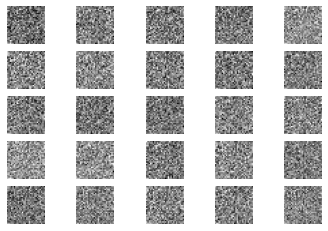

1/1 [==============================] - 0s 14ms/step


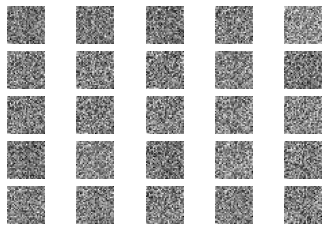

1/1 [==============================] - 0s 14ms/step


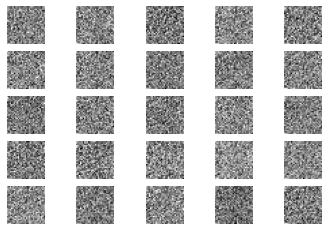

1/1 [==============================] - 0s 20ms/step


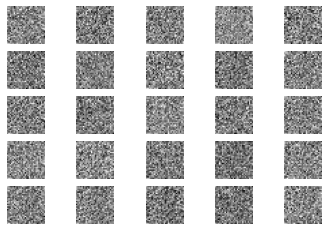

1/1 [==============================] - 0s 16ms/step


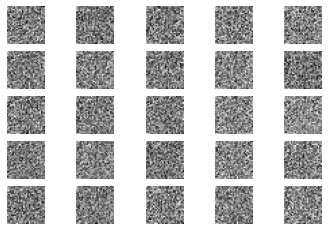

1/1 [==============================] - 0s 14ms/step


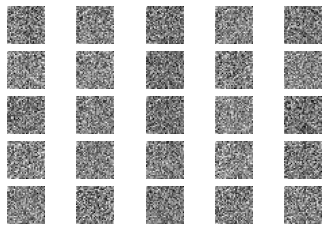

1/1 [==============================] - 0s 14ms/step


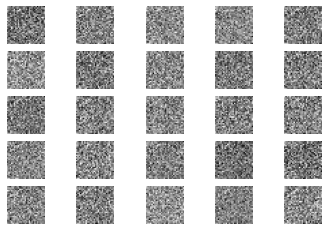

1/1 [==============================] - 0s 15ms/step


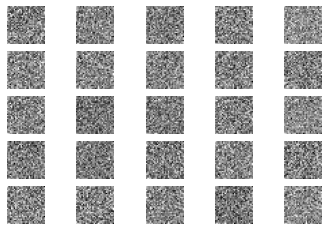

1/1 [==============================] - 0s 14ms/step


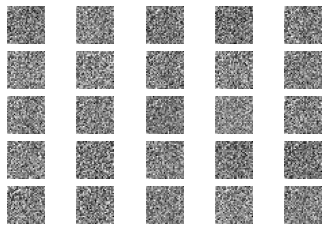

1/1 [==============================] - 0s 14ms/step


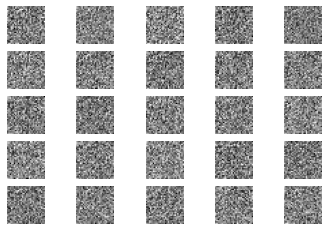

In [ ]:
# TRAINING

# Custom batch of data
batch_size = 32
X_train_batches = []
z_dim = 100
sample_interval = 1000

for it in range(int(len(X_train_batches)/batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    X_train_batches.append(X_train[start_idx:end_idx])

epochs = 10000

for epoch in range(epochs):
  
    fake_label = np.zeros((batch_size,1))
    real_label = np.ones((batch_size,1))

    g_losses = []
    d_losses = []

    for b in range(len(X_train_batches)):
      #......

        noise = np.random.normal(0, 1, (batch_size, z_dim))

        real_img = X_train_batches[b]

        #...
        fake_imgs = generator.predict_on_batch(noise)

        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)

        d_loss_real = discriminator.train_on_batch(real_img, real_label)

        noise = np.random.normal(0, 1, (batch_size, z_dim))
        discriminator.trainable = False

        d_loss = 0.5 + np.add(d_loss_gen, d_loss_real)

        g_loss= GAN.train_on_batch(noise, real_label)
 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss, 100*d_loss, g_loss))

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    g_loss = np.sum(g_losses, axis=0)/ len(g_losses)
    d_loss = np.sum(d_losses,axis=0) / len(d_losses)

    if epoch % sample_interval == 0:
      sample_images(epoch,generator)


##### Create extracting feature block as VGG

First time, I use the simple custom vgg to extract the pattern and using it for replacing the noise of generator because the idea of using image's pattern can highly be convinient for generator. However, the result is bad because the generator completely break the input image without convert it to original image.

In [ ]:
X_train_expand.shape, y_train.shape, X_test_expand.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [ ]:
def extract_feature_model():
    extract_model = Sequential()

    extract_model.add(Conv2D(64, (3,3), activation="relu", padding="same", input_shape=(28, 28, 1)))
    extract_model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
    extract_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    extract_model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
    extract_model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
    extract_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    extract_model.add(Flatten())
    extract_model.add(Dense(2048, activation='relu'))
    extract_model.add(Dense(1024, activation='relu'))
    extract_model.add(Dense(784, activation='sigmoid'))
    extract_model.add(Reshape((28,28,1)))
    return extract_model

In [ ]:
extract_model = extract_feature_model()
extract_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fe246df44d0>>

##### DCGAN of Rohan_Paul_AI

This model is seemly similar to above gan model but I test fail so that I replace completely it by above model to check if my direction of though is right. This model used with VGG model.

In [ ]:
num_samples = len(X_train)

input_shape = (28,28,1)
output_shape = (28,28,1)

input = Input(shape=input_shape)
output = Input(shape=output_shape)


In [ ]:

def generator_model():
  generator=Sequential()
  
  # Random noise to 4x4x512 image
  generator.add(Dense(512, input_shape=[28,28,1]))

  # last layer to a tensor of a shape of (7, 7, 512):
  generator.add(Conv2DTranspose(256, (3,3), strides=1, padding="same"))
  
  # BatchNormalization is added to the model after the hidden layer, but before the activation, such as LeakyReLU.
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))
  
  generator.add(Conv2DTranspose(128, (3,3), strides=1, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(64, (3,3), strides=1, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(1, (3,3), strides=1, padding="same",
                                  activation='sigmoid'))
  return generator
  
generator = generator_model()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 28, 28, 512)       1024      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 256)      1179904   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 256)      1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                      

In [ ]:
def discriminator_model():

  discriminator = Sequential()

  discriminator.add(Conv2D(64, (3,3), strides=(1, 1), padding='same', input_shape=[28,28,1]))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Conv2D(64, (3,3), strides=(1, 1), padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.4))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                      

In [ ]:
GAN =Sequential([generator,discriminator])

discriminator.compile(optimizer='adam',loss='binary_crossentropy')

# When we train this network, we don't want to train the discriminator network, 
# so make it non-trainable before we add it to the adversarial model.
discriminator.trainable = False

GAN.compile(optimizer='adam',loss='binary_crossentropy')

GAN.layers

GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         1552129   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 88001     
                                                                 
Total params: 1,640,130
Trainable params: 1,551,233
Non-trainable params: 88,897
_________________________________________________________________


##### My SRGAN

Remove the idea from using the SRGAN to this problem from the beginning

In [ ]:
# def res_block(ip):
#     res_model = Conv2D(64,(5,5), padding="same")(ip)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)

#     res_model = Conv2D(64, (3,3), padding = "same")(res_model)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)
#     res_model = PReLU(shared_axes = [1,2])(res_model)

#     res_model = Conv2D(64, (3,3), padding = "same")(res_model)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)

#     return add([ip, res_model])

# def upscale_block(ip):
#     up_model = Conv2D(256, (3,3), padding="same")(ip)
#     # add more 3 layers  PReLU, Conv2D, Batch to increase the quality learning 
#     up_model = PReLU(shared_axes=[1,2])(up_model)
#     up_model = Conv2D(256, (3,3), padding="same")(up_model)
#     up_model = BatchNormalization(momentum=0.5)(up_model)
#     up_model = UpSampling2D(size=2)(up_model)
#     up_model = PReLU(shared_axes=[1,2])(up_model)
#     return up_model

# Model GAN with basic layers
# def create_gen(gen_ip):
    
#     layers = Conv2D(64, (9,9),padding = "same")(gen_ip)
#     layers = PReLU(shared_axes=[1,2])(layers)
    
#     # Add 2 more layers
#     layers = Conv2D(64, (5,5),padding = "same")(layers)
#     layers = PReLU(shared_axes=[1,2])(layers)
    
#     # using for skip connection before going to res_blocks
#     temp = layers
    
#     for i in range(5):
#         layers = res_block(layers)
 
#     layers = Conv2D(64, (3,3), padding="same")(layers)
#     layers = BatchNormalization(momentum=0.5)(layers)
#     layers = add([layers, temp])

#     op = Conv2D(1, (9,9), padding="same")(layers) # remove the upscale block 

#     return Model(inputs=gen_ip, outputs=op)

In [ ]:
# def discriminator_block(ip, filters, strides=1, bn=True):
#     disc_model = Conv2D(filters, 3 ,strides = strides, padding="same")(ip)

#     if bn:
#         disc_model = BatchNormalization( momentum=0.8)(disc_model)

#     disc_model = LeakyReLU( alpha=0.3)(disc_model)

#     return disc_model

# def create_disc(disc_ip):
#     # create dis
#     df = 28

#     d1 = discriminator_block(disc_ip, df , bn = False)
#     d2 = discriminator_block(d1, df, strides=2)
#     d3 = discriminator_block(d2, df*2)
#     d4 = discriminator_block(d3, df*2, strides = 2)

#     d5_5 = Flatten()(d4)
#     d6 = Dense(df*4)(d5_5)
#     d7 = LeakyReLU(alpha=0.3)(d6)
#     validity = Dense(1, activation='sigmoid')(d7)

#     return Model(disc_ip, validity)

In [ ]:
# def create_comb(gen_model, disc_model, input, output):
#     gen_img = gen_model(input)
#     disc_model.trainable = False
    
#     validity = disc_model(gen_img)

#     return Model(inputs=[input, output], outputs=[validity])

In [ ]:
# # Model
# import h5py

# generator = create_gen(input)
# generator.summary()

# discriminator = create_disc(output)
# discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
# discriminator.summary()

# gan_model = create_comb(generator,discriminator, input,output)

# gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3,1],optimizer="adam")
# gan_model.summary()

# Running

In [37]:
from numpy.random.mtrand import randint
def get_img_from_cluster(no_cluster):
  return X_train[cluster_indexes[no_cluster][int(randint(0,len(cluster_indexes[no_cluster]),1))]]

In [38]:
# cleaning the input sentence and let the intent_predict_model predict it.
def predictions(text, model_predict_intent):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model_predict_intent.predict(x) 
  return pred


In [39]:
# sort the largest to smallest confidences in predicting intent
def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))
  return classes[0] # best confidence

In [88]:
def get_key(val):
    for key, value in id_to_category.items():
        if val == value:
            return key
 
    return "key doesn't exist"


##### The whole process:
1. Starting from get the intent of user input.
2. The clusering_model figure out the index of cluster which intent belong to.
3. Pick one random imgage from that cluster and apply the preprocessing step before give to the generator. 
4. Let the generator create the final output.

In [84]:
id_to_category # compare

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Shirt',
 3: 'Bag',
 4: 'Dress',
 5: 'Sneaker',
 6: 'Pullover',
 7: 'ankle-boot',
 8: 'Coat',
 9: 'Sandal'}

In [87]:
#def running():
input_user = " Give me a coat"
print(f'You entered {input_user}')
pred = predictions(input_user, model_cnn_predict_intent)
index_cluster_input = get_final_output(pred, category_id_df)
print(index_cluster_input[0])
# print(id_to_category[index_cluster_input[0]])

You entered  Give me a coat
1/1 [==============================] - 0s 58ms/step
['Coat' 8] has confidence = 0.8820502
['Sneaker' 5] has confidence = 0.114696175
['Pullover' 6] has confidence = 0.0028749055
['Bag' 3] has confidence = 0.00027074132
['Shirt' 2] has confidence = 5.6091812e-05
['ankle-boot' 7] has confidence = 3.9048307e-05
['Sandal' 9] has confidence = 9.16765e-06
['Trouser' 1] has confidence = 3.3646807e-06
['T-shirt/top' 0] has confidence = 2.1148274e-07
['Dress' 4] has confidence = 5.977354e-08
Coat


In [93]:
# get the cluster
cluster = get_key(index_cluster_input[0])
cluster

8

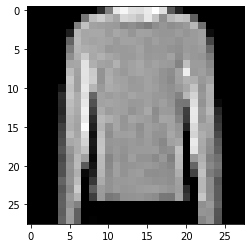

In [108]:
rand_image = get_img_from_cluster(cluster) 
plt.imshow(rand_image.reshape((28,28)),cmap= plt.cm.gray)
plt.show()

In [109]:
img_3dims = np.expand_dims(rand_image, axis = 0)
rand_image.shape
img_4dims = np.expand_dims(img_3dims, axis = -1)
img_4dims.shape

(1, 28, 28, 1)

In [110]:
edge_img_4dims = edge_detect_model.predict(img_4dims)

1/1 [==============================] - 0s 17ms/step


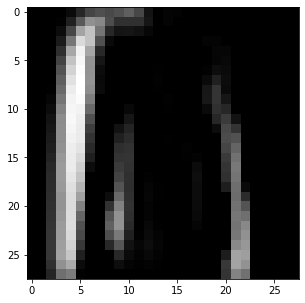

In [111]:
import cv2

noise_test = np.random.normal(0, 1, (1, 28, 28,1))
img_4dims_combined = edge_img_4dims + noise_test

# PLot the combined image
plt.figure(figsize=(5,5))
plt.imshow(edge_img_4dims.reshape((28,28)),cmap= plt.cm.gray)
plt.show()

1/1 [==============================] - 0s 16ms/step


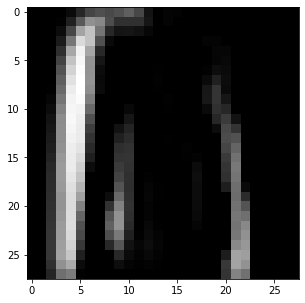

In [112]:
# create new image and from intent input
new_image = generator.predict(img_4dims_combined)

plt.figure(figsize=(5,5))
plt.imshow(edge_img_4dims.reshape((28,28)),cmap= plt.cm.gray)
plt.show()

The ouput show that the model complete convert it to original image but not generate the new one.